In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, robust_scale, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import des données
DF_app=pd.read_excel('/content/drive/MyDrive/Michelin/Sujet 1/Code/Apprentissage2.xlsx',header=0,index_col=0)
DF_app.head()
DF_test=pd.read_excel('/content/drive/MyDrive/Michelin/Sujet 1/Code/Test2.xlsx',header=0,index_col=0)
DF_test.head()
DF_val=pd.read_excel('/content/drive/MyDrive/Michelin/Sujet 1/Code/Validation2.xlsx',header=0,index_col=0)
DF_val.head()

,Imbibition,Load,FrontRear,channel,speed,accelX,accelY,speedClass,ambiantTemperature,band1,...,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,weatherCheck,textureCheck,TireWear
1092,Uimb,4p,front,1,110.62,0.0981,-0.2943,110,0.0,-28.188,...,0.28137,-0.121110,-0.246910,-0.28270,0.116590,0.036574,0.149070,Dry,Rough,TavWorn_TarWorn
1093,Uimb,4p,front,1,110.68,0.0000,-0.2943,110,0.0,-28.018,...,0.35561,0.016176,-0.067164,-0.18313,0.031058,0.097997,0.086952,Dry,Rough,TavWorn_TarWorn
1094,Uimb,4p,front,1,110.56,0.0981,0.0000,110,0.0,-27.462,...,0.42554,0.040436,-0.176970,-0.38058,0.137900,0.091673,0.159820,Dry,Rough,TavWorn_TarWorn
1095,Uimb,4p,front,1,110.68,0.1962,0.0981,110,0.0,-28.475,...,0.28083,-0.167520,-0.199790,-0.19623,0.167320,0.080200,0.132490,Dry,Rough,TavWorn_TarWorn
1096,Uimb,4p,front,1,110.75,0.0981,0.0000,110,0.0,-29.599,...,0.34195,-0.026828,-0.200810,-0.28597,0.083130,0.019094,0.097546,Dry,Rough,TavWorn_TarWorn


In [ ]:
def modif(donnees):
    #on supprime les variables à supprimer
    varSupp=['Load', 'speed']
    for i in varSupp:
        del donnees[i]
    #'accelX'
    donnees["accelX2"]=pd.Series(index=range(donnees.shape[0]),dtype='str')
    donnees.loc[donnees["accelX"]<=(-0.049),"accelX2"]="-0.4905-(-0.049)"
    donnees.loc[(donnees["accelX"]>(-0.049)) & (donnees["accelX"]<=0.049),"accelX2"]="<0.049 - 0.049"
    donnees.loc[donnees["accelX"]>0.049,"accelX2"]=">0.049"

    #'accelY'
    donnees["accelY2"]=pd.Series(index=range(donnees.shape[0]),dtype='str')
    donnees.loc[donnees["accelY"]<=(-0.147),"accelY2"]="<=-0.147"
    donnees.loc[(donnees["accelY"]>(-0.147)) & (donnees["accelY"]<=(-0.049)),"accelY2"]="-0.147 - -0.049"
    donnees.loc[(donnees["accelY"]>(-0.049)) & (donnees["accelY"]<=0.147),"accelY2"]="-0.049 - 0.147"
    donnees.loc[donnees["accelY"]>0.147,"accelY2"]=">0.147"

    #'ambiantTemperature'
    donnees["ambiantTemperature2"]=pd.Series(index=range(donnees.shape[0]),dtype='str')
    donnees.loc[donnees["ambiantTemperature"]<=1.616,"ambiantTemperature2"]="0-1.616"
    donnees.loc[(donnees["ambiantTemperature"]>1.616) & (donnees["ambiantTemperature"]<=7.05),"ambiantTemperature2"]="1.616 - 7.05"
    donnees.loc[(donnees["ambiantTemperature"]>7.05) & (donnees["ambiantTemperature"]<=11.55),"ambiantTemperature2"]="7.05 - 11.55"
    donnees.loc[donnees["ambiantTemperature"]>11.55,"ambiantTemperature2"]=">11.55"

    #on supprimer les colonnes qu on à modifiés
    varMod=['accelX', 'accelY', 'ambiantTemperature']
    for i in varMod:
        del donnees[i]
    #on transforme les variables garder en str
    varGard=['Imbibition', 'FrontRear', 'channel', 'speedClass']
    for i in varGard:
        donnees[i]=donnees[i].astype("str")

    Liste_y = ['weatherCheck', 'textureCheck', 'TireWear']
    for var in Liste_y:
        var_pred = donnees.pop(var)
        donnees.insert(donnees.shape[1], var, var_pred)
    return donnees

In [ ]:
DF_A = DF_app.copy()
DF_T = DF_test.copy()
DF_V = DF_val.copy()

In [ ]:
print(DF_A.shape)

(41610, 136)


In [ ]:
DF_A = modif(DF_A)
DF_T = modif(DF_T)
DF_V = modif(DF_V)

In [ ]:
print(DF_A.shape)

(41610, 134)


In [ ]:
lstQuali = [var for var in DF_A.columns[:-3] if DF_A[var].dtype == np.object_]

dfQualiEncoded = pd.get_dummies(DF_A[lstQuali])
for var in lstQuali :
    del DF_A[var]
DF_A= pd.concat([dfQualiEncoded, DF_A],axis=1)

dfQualiEncoded = pd.get_dummies(DF_T[lstQuali])
for var in lstQuali :
    del DF_T[var]
DF_T= pd.concat([dfQualiEncoded,DF_T],axis=1)

dfQualiEncoded = pd.get_dummies(DF_V[lstQuali])
for var in lstQuali :
    del DF_V[var]
DF_V= pd.concat([dfQualiEncoded,DF_V],axis=1)

In [ ]:
print(DF_A.shape)

(41610, 150)


In [ ]:
DF_A.columns

Index(['Imbibition_Imb', 'Imbibition_Nimb', 'Imbibition_Uimb',
       'FrontRear_front', 'FrontRear_rear', 'channel_1', 'channel_2',
       'speedClass_110', 'speedClass_30', 'speedClass_50',
       ...
       'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13',
       'weatherCheck', 'textureCheck', 'TireWear'],
      dtype='object', length=150)

In [ ]:
DF_T.columns

Index(['Imbibition_Imb', 'Imbibition_Nimb', 'Imbibition_Uimb',
       'FrontRear_front', 'FrontRear_rear', 'channel_1', 'channel_2',
       'speedClass_110', 'speedClass_30', 'speedClass_50',
       ...
       'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13',
       'weatherCheck', 'textureCheck', 'TireWear'],
      dtype='object', length=150)

In [ ]:
DF_V.columns

Index(['Imbibition_Imb', 'Imbibition_Nimb', 'Imbibition_Uimb',
       'FrontRear_front', 'FrontRear_rear', 'channel_1', 'channel_2',
       'speedClass_110', 'speedClass_30', 'speedClass_50',
       ...
       'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13',
       'weatherCheck', 'textureCheck', 'TireWear'],
      dtype='object', length=150)

In [ ]:
X_app = DF_A[DF_A.columns[:-3]]
Y_app = DF_A[DF_A.columns[-3:]]
X_test = DF_T[DF_T.columns[:-3]]
Y_test = DF_T[DF_T.columns[-3:]]
X_valid = DF_V[DF_V.columns[:-3]]
Y_valid = DF_V[DF_V.columns[-3:]]
print(X_app.shape)
print(Y_test.columns)

(41610, 147)
Index(['weatherCheck', 'textureCheck', 'TireWear'], dtype='object')


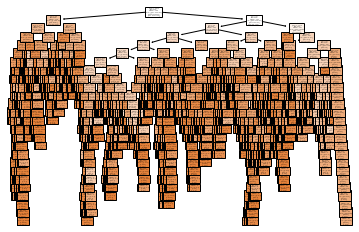

depth= 25 leaf= 10
[[ 451    2  162]
 [   0 7999    0]
 [ 242    1 1997]]
0.9625023032983232
[[3820  101  665]
 [ 478 2960   19]
 [ 599   41 2171]]
0.8246729316381057
[[ 747   17 1150]
 [  38 1619  964]
 [ 950  893 4476]]
0.6303666850930533




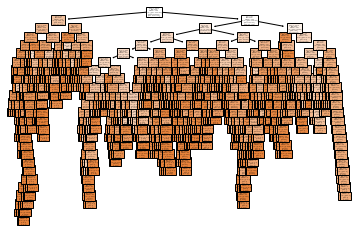

depth= 25 leaf= 25
[[ 456   10  149]
 [   0 7999    0]
 [ 245   14 1981]]
0.9614888520361157
[[3796   56  734]
 [ 233 3176   48]
 [ 582    5 2224]]
0.8472452552054542
[[ 876   44  994]
 [  36 1685  900]
 [ 978  704 4637]]
0.6631656532154044




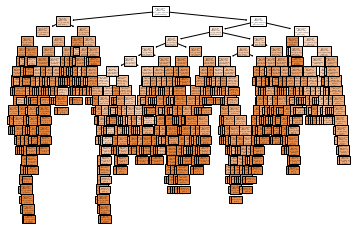

depth= 25 leaf= 50
[[ 472   12  131]
 [   0 7999    0]
 [ 246    4 1990]]
0.9637921503593145
[[4047   51  488]
 [ 114 3296   47]
 [ 497   75 2239]]
0.882808181315644
[[ 805   13 1096]
 [  36 1656  929]
 [ 333 1068 4918]]
0.6798415330753639




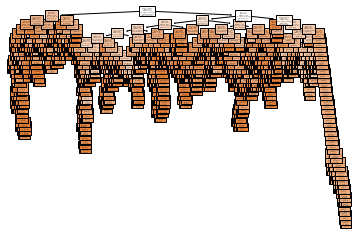

depth= 50 leaf= 10
[[ 451    2  162]
 [   0 7999    0]
 [ 242    1 1997]]
0.9625023032983232
[[3851   71  664]
 [ 485 2955   17]
 [ 604   37 2170]]
0.8269762299613046
[[ 745   17 1152]
 [   2 1632  987]
 [ 959  777 4583]]
0.6412382531785517




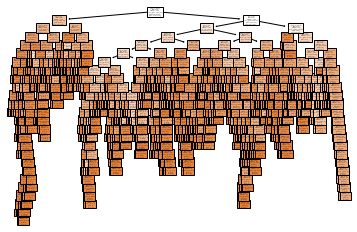

depth= 50 leaf= 25
[[ 456   10  149]
 [   0 7999    0]
 [ 245   14 1981]]
0.9614888520361157
[[3808   56  722]
 [ 265 3142   50]
 [ 527    1 2283]]
0.8506541367237884
[[ 855   45 1014]
 [   0 1690  931]
 [ 978  598 4743]]
0.6714575271789203




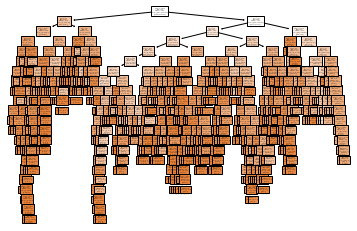

depth= 50 leaf= 50
[[ 472   12  131]
 [   0 7999    0]
 [ 246    4 1990]]
0.9637921503593145
[[4047   51  488]
 [ 115 3295   47]
 [ 494   79 2238]]
0.8826239174497881
[[ 800   13 1101]
 [   0 1657  964]
 [ 331 1065 4923]]
0.6799336650082919




In [ ]:
depth=[25,50]
leaf=[10,25,50]
for dep in depth:
    for lea in leaf:
        arbre1=DecisionTreeClassifier(max_depth=dep,min_samples_leaf=lea)
        arbre1.fit(X_app,Y_app)
        plot_tree(arbre1, filled=True)
        plt.show()
        print("depth=",dep,"leaf=",lea)

        predfirst=arbre1.predict(X=X_test)

        print(confusion_matrix(Y_test['weatherCheck'], predfirst[:,0]))
        print(metrics.accuracy_score(Y_test['weatherCheck'],predfirst[:,0]))

        print(confusion_matrix(Y_test['textureCheck'], predfirst[:,1]))
        print(metrics.accuracy_score(Y_test['textureCheck'],predfirst[:,1]))

        print(confusion_matrix(Y_test['TireWear'], predfirst[:,2]))
        print(metrics.accuracy_score(Y_test['TireWear'],predfirst[:,2]))

        print("\n")

In [ ]:
print(X_app.shape)

In [ ]:
arbrefinale=DecisionTreeClassifier(max_depth=50,min_samples_leaf=50)
arbrefinale.fit(X_app,Y_app)
predvalid=arbrefinale.predict(X=X_valid)
print(metrics.accuracy_score(Y_valid['weatherCheck'],predvalid[:,0]))
print(metrics.accuracy_score(Y_valid['textureCheck'],predvalid[:,1]))
print(metrics.accuracy_score(Y_valid['TireWear'],predvalid[:,2]))

print(metrics.confusion_matrix(Y_valid['TireWear'],predvalid[:,2]))

0.9944324712643678
0.7948994252873564
0.7776580459770115
[[ 687    0  225]
 [ 241 2094  381]
 [ 311   80 1549]]


In [ ]:
DF_first=pd.read_excel('/content/drive/MyDrive/Michelin/Sujet 1/Code/First.xlsx',header=0,index_col=0)
DF_first.head()
DF_second=pd.read_excel('/content/drive/MyDrive/Michelin/Sujet 1/Code/Second.xlsx',header=0,index_col=0)
DF_second.head()

In [ ]:
print(DF_first.shape)
print(DF_second.shape)

In [ ]:
DF_F = DF_first.copy()
DF_S = DF_second.copy()

In [ ]:
print(DF_F.shape)
print(DF_F.shape)

In [ ]:
#On part du principe que Imb = Uimb
print(DF_F['Imbibition'].unique())
print(DF_S['Imbibition'].unique())

In [ ]:
DF_F = modif(DF_F)
DF_S = modif(DF_S)

In [ ]:
print(DF_F.shape)
print(DF_F.shape)

In [ ]:
dfQualiEncoded = pd.get_dummies(DF_F[lstQuali])
for var in lstQuali :
    del DF_F[var]
DF_F= pd.concat([dfQualiEncoded, DF_F],axis=1)

dfQualiEncoded = pd.get_dummies(DF_S[lstQuali])
for var in lstQuali :
    del DF_S[var]
DF_S= pd.concat([dfQualiEncoded, DF_S],axis=1)

In [ ]:
print(DF_F.shape)
print(DF_S.shape)

In [ ]:
for i in DF_A.columns :
  if i not in DF_F.columns:
    print(i)

In [ ]:
for i in DF_A.columns :
  if i not in DF_S.columns:
    print(i)

In [ ]:
print(DF_A.columns)

In [ ]:
ListManqueF=['Imbibition_Nimb',
'Imbibition_Uimb',
'ambiantTemperature2_1.616 - 7.05',
'ambiantTemperature2_7.05 - 11.55',
'ambiantTemperature2_>11.55']

ListManqueS=['Imbibition_Imb',
'Imbibition_Uimb',
'ambiantTemperature2_1.616 - 7.05',
'ambiantTemperature2_7.05 - 11.55',
'ambiantTemperature2_>11.55']

for i in range (len(DF_A.columns)):
  if DF_A.columns[i] in ListManqueF :
    DF_F.insert(i, DF_A.columns[i], 0, allow_duplicates=False)

for i in range (len(DF_A.columns)):
  if DF_A.columns[i] in ListManqueS :
    DF_S.insert(i, DF_A.columns[i], 0, allow_duplicates=False)

In [ ]:
print(DF_F.shape)
print(DF_S.shape)

In [ ]:
print(DF_F.columns)
print(DF_S.columns)

In [ ]:
X_first = DF_F[DF_F.columns[:-3]]
Y_first = DF_F[DF_F.columns[-3:]]
X_second = DF_S[DF_S.columns[:-3]]
Y_second = DF_S[DF_S.columns[-3:]]
print(X_first.shape)
predFirst=arbrefinale.predict(X=X_first)

predSecond=arbrefinale.predict(X=X_second)

In [ ]:
print(predFirst)
print(predSecond)

In [ ]:
column_names = ['weatherCheck', 'textureCheck', 'TireWear']

Y_First = pd.DataFrame(predFirst, columns=column_names)
Y_Second = pd.DataFrame(predSecond, columns=column_names)

In [ ]:
print(Y_First)
print(Y_Second)

In [ ]:
Y_First.to_excel('/content/drive/MyDrive/Michelin/Sujet 1/Code/FirstTrip_Y.xlsx')

Y_Second.to_excel('/content/drive/MyDrive/Michelin/Sujet 1/Code/SecondTrip_Y.xlsx')